### Import Libraries & Modules

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import json
import re
import requests
import string
import matplotlib.pyplot as plt

import spacy
from textblob import TextBlob
tokens = spacy.load("en_core_web_sm")
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from functools import reduce
from collections import Counter
from itertools import chain

import nltk
nltk.download("stopwords")
nltk.download('brown')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import norm
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.metrics import edit_distance

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

import torch
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split 


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Using device: cuda


### Import Data

In [3]:
datapath = '/kaggle/input/data-model/final_data.csv'
data = pd.read_csv(datapath)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data = data.groupby('Target', as_index=False)['Clues'].agg(', '.join)
data = data.dropna(axis=0)
print(data.shape)
data.sample(10)

(125073, 2)


,Target,Clues
36613,briefly,"short time, ibm short time, concise manner"
9475,GMT,time
35653,bonderize,bonderize steel coat
113393,sympathy vengeance,year imprisonment old boy lee guem ja boy deat...
70724,hour_circle,great_circle
53347,empiricism,"medical_practice, philosophical_doctrine, inve..."
117353,traveling_bag,baggage
94490,polymerization,chemical_process
90740,part_to_whole_relation,"part, semantic_relation"
33853,beverage,"beverage order, liquid, food"


### Word2Vec Model with Skip-Gram

In [4]:
def tokenizer(sentence):
    sentence = sentence.replace('_', ' ')
    return word_tokenize(sentence)

tokenized_data_target = [tokenizer(str(sentence)) for sentence in data['Target']]
tokenized_data_clues = [tokenizer(str(sentence)) for sentence in data['Clues']]
tokenized_data_combined = tokenized_data_target + tokenized_data_clues

w2v_model = Word2Vec(sentences=tokenized_data_combined, vector_size=100, window=5, min_count=1, sg=1, workers=4)

### Neural Network Model

In [5]:
input_tokens = [word.split(', ') for word in data['Clues']]
output_tokens = [word.split('_') for word in data['Target']]

all_tokens = [token for sublist in input_tokens + output_tokens for token in sublist]

unique_tokens = list(set(all_tokens))

word_to_index = {word: idx + 1 for idx, word in enumerate(unique_tokens)}

input_indices = [[word_to_index[word] for word in tokens] for tokens in input_tokens]
output_indices = [[word_to_index[word] for word in tokens] for tokens in output_tokens]

In [6]:
input_indices_train, input_indices_test, output_indices_train, output_indices_test = train_test_split(
    input_indices, output_indices, test_size=0.2, random_state=42)

input_indices_padded_train = pad_sequences(input_indices_train, padding='post')
output_indices_padded_train = pad_sequences(output_indices_train, padding='post', maxlen=input_indices_padded_train.shape[1])

input_indices_padded_test = pad_sequences(input_indices_test, padding='post', maxlen=input_indices_padded_train.shape[1])
output_indices_padded_test = pad_sequences(output_indices_test, padding='post', maxlen=input_indices_padded_train.shape[1])

embedding_matrix = np.zeros((len(word_to_index) + 1, w2v_model.vector_size))
for word, idx in word_to_index.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

num_classes = len(unique_tokens) + 1

In [7]:
model = Sequential()
model.add(Embedding(input_dim=len(word_to_index) + 1, output_dim=w2v_model.vector_size, input_length=input_indices_padded_train.shape[1], trainable=False, weights=[embedding_matrix]))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5)) 
model.add(Dense(len(word_to_index) + 1, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    input_indices_padded_train, output_indices_padded_train,
    validation_data=(input_indices_padded_test, output_indices_padded_test),
    epochs=3)

Epoch 1/3
3127/3127 [==============================] - 2040s 651ms/step - loss: 0.3403 - accuracy: 0.9915 - val_loss: 0.0992 - val_accuracy: 0.9917
Epoch 2/3
3127/3127 [==============================] - 2045s 654ms/step - loss: 0.0980 - accuracy: 0.9917 - val_loss: 0.0966 - val_accuracy: 0.9917
Epoch 3/3
3127/3127 [==============================] - 2047s 655ms/step - loss: 0.0945 - accuracy: 0.9917 - val_loss: 0.0965 - val_accuracy: 0.9917


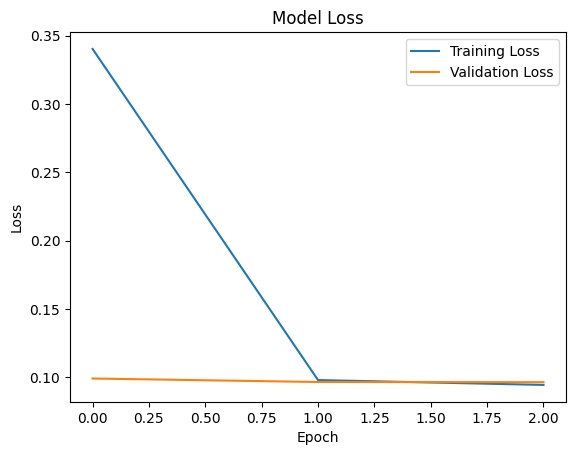

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
index_to_word = {idx: word for word, idx in word_to_index.items()}

input_words = ['mother', 'father', 'son', 'daughter']
input_indices = [word_to_index[word] for word in input_words]
input_indices_padded = pad_sequences([input_indices], padding='post', maxlen=input_indices_padded_train.shape[1])

predictions = model.predict(input_indices_padded)
predicted_word_indices = np.argmax(predictions, axis=2)[0]
predicted_words = [index_to_word.get(idx, '') for idx in predicted_word_indices]

print(input_words, '\n')
print(f"The predicted words related to the input set are: {predicted_words[0]}")

1/1 [==============================] - 0s 23ms/step
['mother', 'father', 'son', 'daughter'] 

The predicted words related to the input set are: genus
